In [1]:
import os, sys
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils.detection import find_peaks
from astropy.table import Table
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder

%matplotlib inline

In [2]:
from astropy.io import fits

with fits.open('sdss_g_sci.fits') as hdul:
    hdul.info()

'''
sdss_g
sdss_i
sdss_r
sdss_u
sdss_z
'''

Filename: sdss_g_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     132   (1024, 1024)   float64   


In [59]:
filters = ['sdss_g','sdss_r','sdss_i','sdss_z']
nbands = len(filters)

print ("Number of filters: %d" % nbands)
fil_names = ['SDSS_G','SDSS_R','SDSS_I','SDSS_Z']

# directory of the images
dir_images = '/mnt/d/pixedfit_testing/ARCSAT/first_attempt/'

sci_img = {}
sci_img['sdss_g'] = 'sdss_g_sci.fits'
sci_img['sdss_r'] = 'sdss_r_sci.fits'
sci_img['sdss_i'] = 'sdss_i_sci.fits'
sci_img['sdss_z'] = 'sdss_z_sci.fits'

err_img = {}
err_img['sdss_g'] = 'sdss_g_err.fits'
err_img['sdss_r'] = 'sdss_r_err.fits'
err_img['sdss_i'] = 'sdss_i_err.fits'
err_img['sdss_z'] = 'sdss_z_err.fits'

# Get pixel sizes of the images
from piXedfit.piXedfit_images import calc_pixsize

img_pixsize = np.zeros(nbands)
for bb in range(0,nbands):
    img_pixsize[bb] = calc_pixsize(dir_images+sci_img[filters[bb]])
    
print (img_pixsize.tolist())

# define sizes of the PSF stamps that will be produced
psf_size = np.zeros(nbands)
for bb in range(0,nbands):
    psf_size[bb] = 55
print (psf_size)

Number of filters: 4
[0.6700470936733434, 0.6704457470351916, 0.6703111708581303, 0.6704357586585542]
[55. 55. 55. 55.]


In [60]:
id_fil = 3
print (filters[int(id_fil)])

hdu = fits.open(dir_images+sci_img[filters[int(id_fil)]])
data_sci = hdu[0].data
hdu.close()

hdu = fits.open(dir_images+err_img[filters[int(id_fil)]])
data_err = 1.0/np.sqrt(hdu[0].data)
hdu.close()

peaks_tbl = find_peaks(data_sci, threshold=1e-4, error=data_err) 
peaks_tbl = peaks_tbl[np.argsort(peaks_tbl['peak_value'])[::-1]]
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output 
print(peaks_tbl)

print ('Number of stars: %d' % len(peaks_tbl['x_peak']))

sdss_z
x_peak y_peak   peak_value 
------ ------ -------------
   656    957  0.0058244393
   665    957  0.0058244393
   289    313  0.0058244393
   288    313  0.0058244393
   287    313  0.0058244393
   470   1022  0.0057837536
   661    955  0.0057605962
   659    956  0.0057506152
   662    958  0.0057323748
   660    959  0.0056997795
   ...    ...           ...
   509    721 0.00011510003
   736    723 0.00011432384
   536    561 0.00011340154
   991    336 0.00011164875
   925    950 0.00011037309
   596    756 0.00010965619
   921    267 0.00010858998
   287    861 0.00010555474
   507    474 0.00010474018
   890    947 0.00010199508
Length = 90 rows
Number of stars: 90


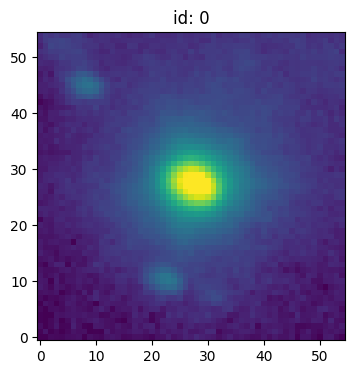

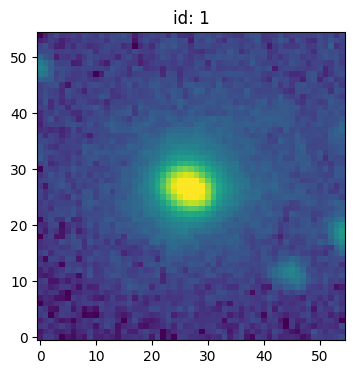

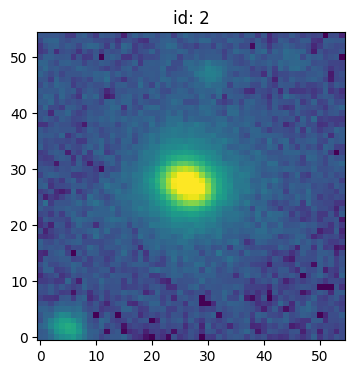

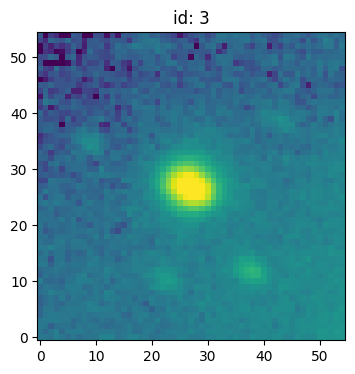

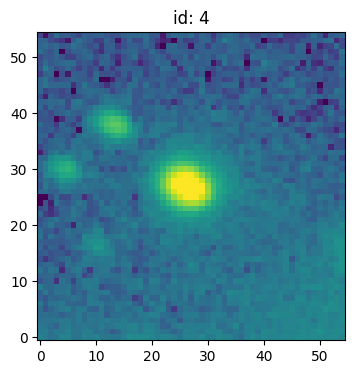

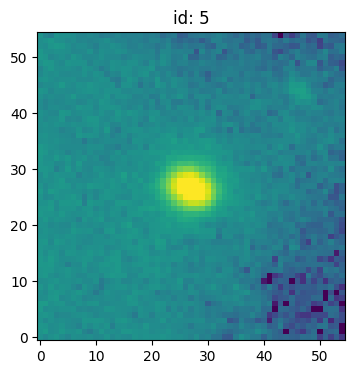

In [61]:
%matplotlib inline
#idx_incld = np.arange(len(peaks_tbl['x_peak']))
idx_incld = np.asarray([4,12,13,19,23,32,])
# SDSS_G: [2,4,5,6,8,10,11,12,13,16]
# SDSS_R: [49,50,51,53,54,56,58,62,74,79]
# SDSS_I: [22,23,25,29,30,40,44,46,47]

mask = [False for i in range(len(peaks_tbl['x_peak']))]
for ii in range(len(idx_incld)):
    mask[int(idx_incld[ii])] = True
    
stars_tbl = Table()
stars_tbl['x'] = peaks_tbl['x_peak'][mask]  
stars_tbl['y'] = peaks_tbl['y_peak'][mask]

nddata = NDData(data=data_sci)
stars = extract_stars(nddata, stars_tbl, size=psf_size[int(id_fil)]) 

for ii in range(0,len(stars)):
    plt.figure(figsize=(4,4))
    plt.subplot()
    norm = simple_norm(stars[ii], 'log', percent=99.)
    plt.imshow(stars[ii], norm=norm, origin='lower', cmap='viridis')
    plt.title('id: %d' % ii)
    plt.show()

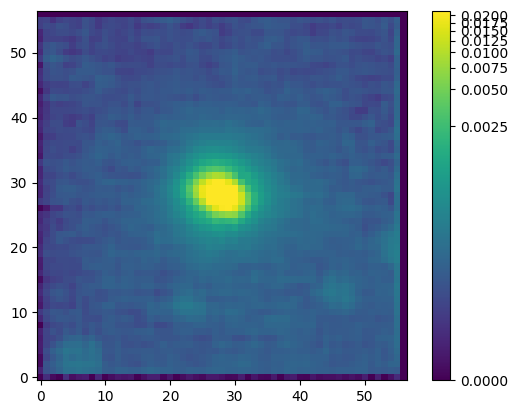

In [62]:
epsf_builder = EPSFBuilder(oversampling=1, maxiters=3, progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars) 

norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

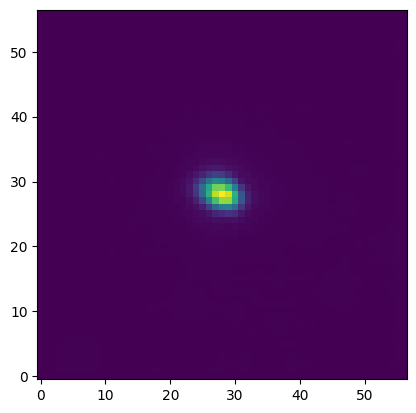

In [63]:
name_out = 'PSF_%s.fits' % fil_names[int(id_fil)]
fits.writeto(name_out, epsf.data, overwrite=True)

hdu = fits.open(name_out)
plt.imshow(hdu[0].data, origin='lower')
plt.show()
hdu.close()

In [64]:
import os, sys
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

%matplotlib inline

In [65]:
print ("Number of filters: %d" % nbands)

pixsize_image = [0.6700470936733434, 0.6704457470351916, 0.6703111708581303, 0.6704357586585542]

# make dictionary for the names of PSF images
psf_image = {}
for bb in range(0,nbands):
    psf_image[filters[bb]] = 'PSF_%s.fits' % fil_names[bb]

# make dictionary for the pixel size of the PSF images
pixsize = {}
for ii in range(0,nbands):
    pixsize[filters[ii]] = pixsize_image[ii]

Number of filters: 4


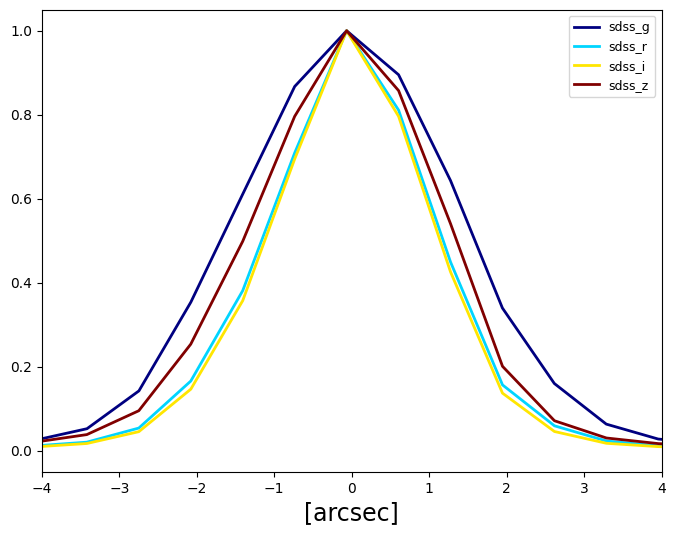

In [68]:
%matplotlib inline

from piXedfit.piXedfit_images import radial_profile_psf

cmap = plt.get_cmap('jet', nbands)

fig1 = plt.figure(figsize=(8,6))
f1 = plt.subplot()
plt.xlim(-4,4)
plt.xlabel('[arcsec]', fontsize=17)

for bb in range(nbands):
    psf_rad, psf_val = radial_profile_psf(psf_image[filters[bb]], pixsize[filters[bb]])
    
    plt.plot(psf_rad, psf_val, lw=2, color=cmap(bb), label=filters[bb])
    
plt.legend(fontsize=9)
plt.show()

In [69]:
from piXedfit.piXedfit_images import create_psf_matching_kernel
from piXedfit.piXedfit_images import test_psfmatching_kernel

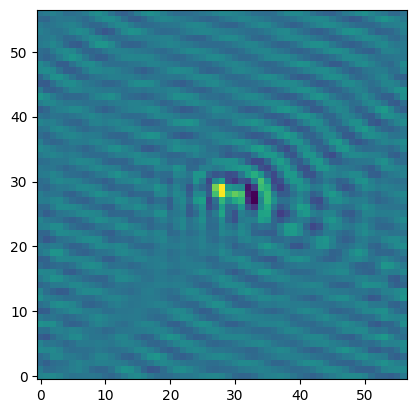

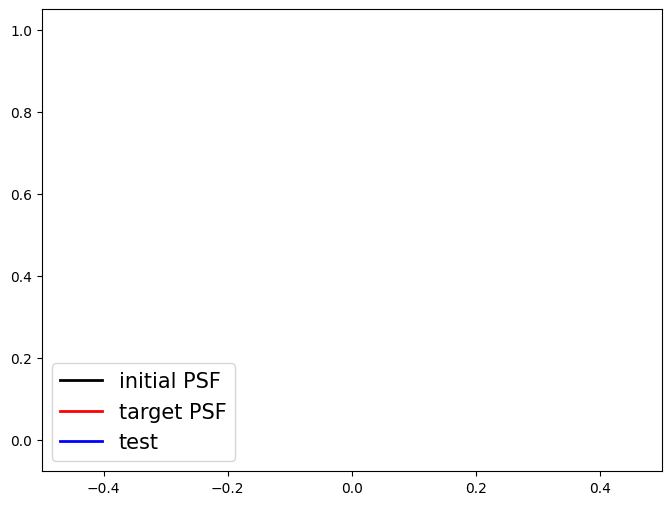

In [72]:
id_fil = 0
id_fil_target = 3

init_PSF_name = psf_image[filters[int(id_fil)]]
target_PSF_name = psf_image['sdss_z']
pixscale_init_PSF = pixsize[filters[int(id_fil)]]
pixscale_target_PSF = pixsize['sdss_z']
kernel = create_psf_matching_kernel(init_PSF_name, target_PSF_name, pixscale_init_PSF, pixscale_target_PSF, window='cosine_bell', window_arg=1.0)

plt.figure()
plt.imshow(kernel, origin='lower')

# test the kernel
test_psfmatching_kernel(init_PSF_name, target_PSF_name, kernel, pixscale_init_PSF, pixscale_target_PSF, dr_arcsec=0.05)

# store the kernel into FITS file
name_out = 'kernel_%s_to_%s.fits' % (fil_names[int(id_fil)],fil_names[int(id_fil_target)])
fits.writeto(name_out, kernel, overwrite=True)

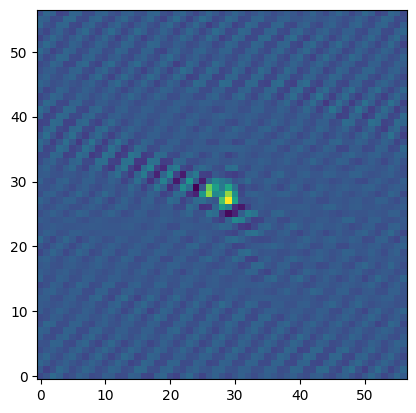

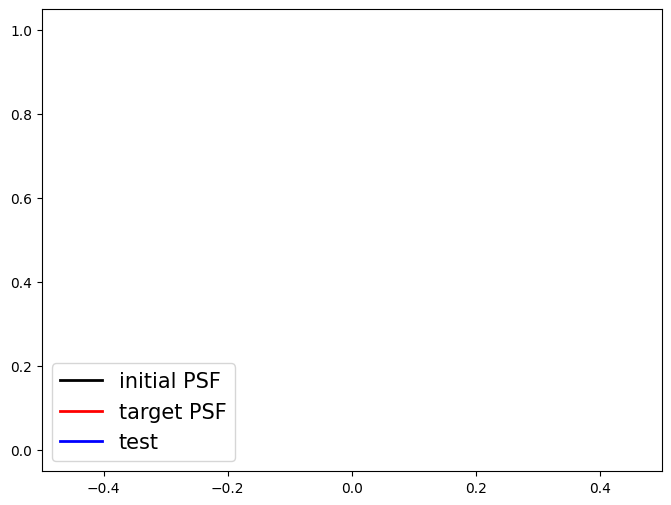

In [74]:
id_fil = 1
id_fil_target = 3

init_PSF_name = psf_image[filters[int(id_fil)]]
target_PSF_name = psf_image['sdss_z']
pixscale_init_PSF = pixsize[filters[int(id_fil)]]
pixscale_target_PSF = pixsize['sdss_z']
kernel = create_psf_matching_kernel(init_PSF_name, target_PSF_name, pixscale_init_PSF, pixscale_target_PSF, window='cosine_bell', window_arg=1.0)

plt.figure()
plt.imshow(kernel, origin='lower')

# test the kernel
test_psfmatching_kernel(init_PSF_name, target_PSF_name, kernel, pixscale_init_PSF, pixscale_target_PSF, dr_arcsec=0.05)

# store the kernel into FITS file
name_out = 'kernel_%s_to_%s.fits' % (fil_names[int(id_fil)],fil_names[int(id_fil_target)])
fits.writeto(name_out, kernel, overwrite=True)

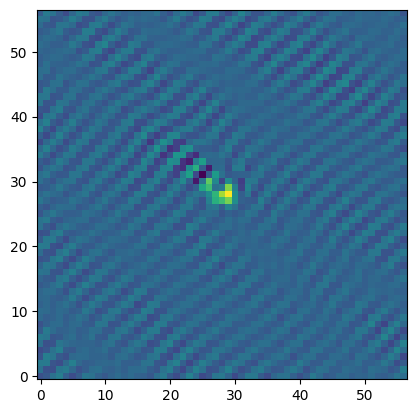

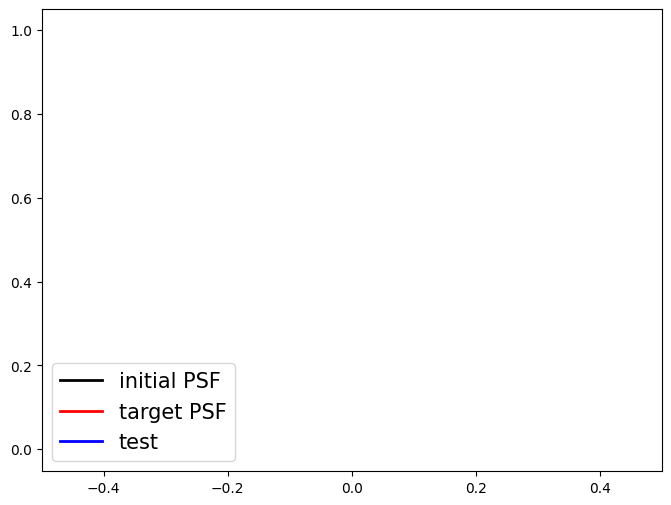

In [75]:
id_fil = 2
id_fil_target = 3

init_PSF_name = psf_image[filters[int(id_fil)]]
target_PSF_name = psf_image['sdss_z']
pixscale_init_PSF = pixsize[filters[int(id_fil)]]
pixscale_target_PSF = pixsize['sdss_z']
kernel = create_psf_matching_kernel(init_PSF_name, target_PSF_name, pixscale_init_PSF, pixscale_target_PSF, window='cosine_bell', window_arg=1.0)

plt.figure()
plt.imshow(kernel, origin='lower')

# test the kernel
test_psfmatching_kernel(init_PSF_name, target_PSF_name, kernel, pixscale_init_PSF, pixscale_target_PSF, dr_arcsec=0.05)

# store the kernel into FITS file
name_out = 'kernel_%s_to_%s.fits' % (fil_names[int(id_fil)],fil_names[int(id_fil_target)])
fits.writeto(name_out, kernel, overwrite=True)

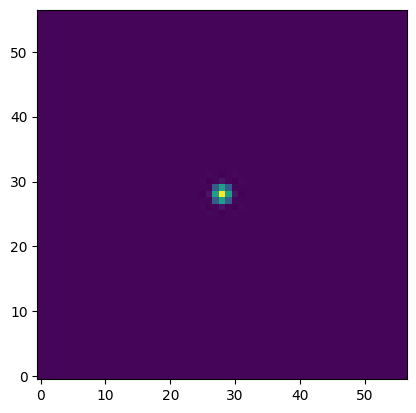

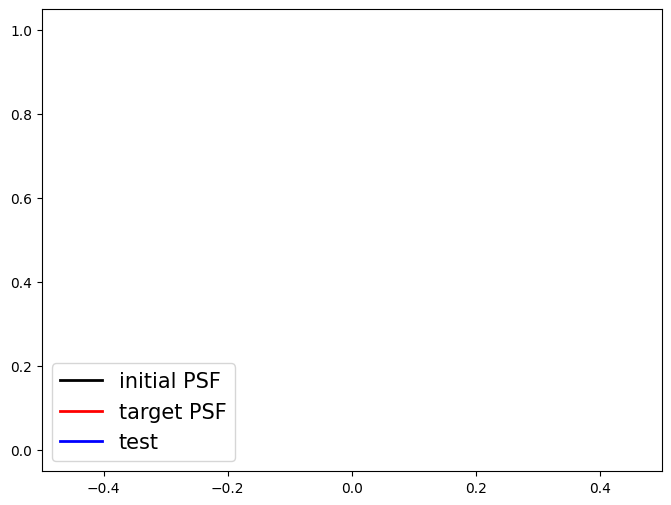

In [76]:
id_fil = 3
id_fil_target = 3

init_PSF_name = psf_image[filters[int(id_fil)]]
target_PSF_name = psf_image['sdss_z']
pixscale_init_PSF = pixsize[filters[int(id_fil)]]
pixscale_target_PSF = pixsize['sdss_z']
kernel = create_psf_matching_kernel(init_PSF_name, target_PSF_name, pixscale_init_PSF, pixscale_target_PSF, window='cosine_bell', window_arg=1.0)

plt.figure()
plt.imshow(kernel, origin='lower')

# test the kernel
test_psfmatching_kernel(init_PSF_name, target_PSF_name, kernel, pixscale_init_PSF, pixscale_target_PSF, dr_arcsec=0.05)

# store the kernel into FITS file
name_out = 'kernel_%s_to_%s.fits' % (fil_names[int(id_fil)],fil_names[int(id_fil_target)])
fits.writeto(name_out, kernel, overwrite=True)